In [1]:
import torch
import sys
# add parent directory to the front of sys.path
sys.path.insert(0, '..')
import sdfvaemodel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = sdfvaemodel.Net().to(device)
model.load_state_dict(torch.load("../pointnet_vaesdf.pth", weights_only=True))
model.eval()

Net(
  (sa1_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(4, 64, 64, 128), global_nn=None)
  )
  (sa2_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(131, 128, 128, 256), global_nn=None)
  )
  (sa3_module): GlobalSAModule(
    (nn): MLP(259, 256, 512, 1024)
  )
  (encode): MLP(1024, 512)
  (mlp_mu): MLP(512, 512)
  (mlp_logvar): MLP(512, 512)
  (sdf1): MLP(515, 256, 128)
  (sdf2): MLP(131, 64, 1)
)

In [2]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 10

# load dataset
dataset = du.SDFDataset("../cars100")
train_percent = 00.01


# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 1, Validation dataset size: 99


In [ ]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    coords = batch[..., :3]   # [B, N, 3]
    sdfs   = batch[...,  3]   # [B, N]

    idx_in = torch.stack([
        torch.randperm(N, device=batch.device)[:np_in]
        for _ in range(B)
    ], dim=0)               # [B, np_in] # random samples

    idx_q  = torch.stack([
        torch.randperm(N, device=batch.device)[:np_q]
        for _ in range(B)
    ], dim=0)               # [B, np_q] # random samples

    batch_ids = torch.arange(B, device=batch.device).unsqueeze(1)
    pos = coords[batch_ids, idx_in]       # [B, np_in,  3]
    x = sdfs[batch_ids, idx_in].unsqueeze(-1)  # [B, np_in, 1]

    query_pos = coords[batch_ids, idx_q]        # [B, np_q,  3]
    query_sdf = sdfs[batch_ids, idx_q].unsqueeze(-1)          # [B, np_q, 1]

    pos = pos.reshape(-1, 3).contiguous()      # [B*np_in, 3]
    x = x.reshape(-1, 1).contiguous()        # [B*np_in, 1]
    batch_idx = batch_ids.repeat(1, np_in)           # [B, np_in]
    batch_idx = batch_idx.reshape(-1).contiguous()   # [B*np_in]
    
    return x.to(device), pos.to(device), batch_idx.to(device), query_pos.to(device), query_sdf.to(device)

In [4]:

batch = next(iter(val_loader))
print(f'Batch shape: {batch.shape}')
x, pos, batch, query_pos, query_sdf = process_batch(batch)

x_encoded, _, _ = model.encoder(x, pos, batch)

z, mu, logvar = model.vae(x_encoded)



Batch shape: torch.Size([10, 50000, 4])


c:\Users\maxde\anaconda3\envs\final311\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [9]:
all_z = []

for batch in val_loader:
    print(f'Batch shape: {batch.shape}')
    x, pos, batch, query_pos, query_sdf = process_batch(batch)

    x_encoded, _, _ = model.encoder(x, pos, batch)

    z, mu, logvar = model.vae(x_encoded)
    all_z.append(z.detach().cpu())

all_z = torch.cat(all_z, dim=0)
print(all_z.shape)

Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([10, 50000, 4])
Batch shape: torch.Size([9, 50000, 4])
torch.Size([99, 512])


In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [12]:
print(all_z.shape)

torch.Size([99, 512])


C:\Users\maxde\AppData\Local\Temp\ipykernel_26380\3970445064.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_tsne[:, 0], z_tsne[:, 1], cmap='viridis', s=5)
C:\Users\maxde\AppData\Local\Temp\ipykernel_26380\3970445064.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_pca[:, 0], z_pca[:, 1], cmap='viridis', s=5)


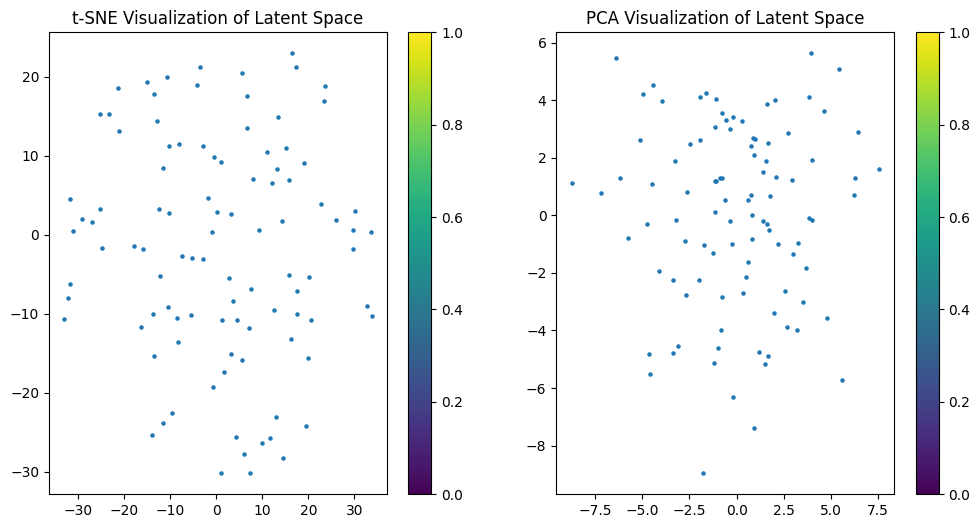

In [13]:
# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
z_tsne = tsne.fit_transform(all_z.detach().cpu())

# Visualize using PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(all_z.detach().cpu())

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], cmap='viridis', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of Latent Space')

plt.subplot(1, 2, 2)
plt.scatter(z_pca[:, 0], z_pca[:, 1], cmap='viridis', s=5)
plt.colorbar()
plt.title('PCA Visualization of Latent Space')

plt.show()